In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import copy
import scipy
from scipy.stats import multivariate_normal
import pandas as pd
from functools import reduce

In [39]:
# compute ln(exp^e1+expe2....)
def ln_sum_exp(Z):
    return np.log(np.sum(np.exp(Z)))

def get_log_likelihood(data, weights, means, covs):
    n_clusters = len(means)
    dimension = len(data[0]) 
    sum_ln_exp = 0
    for d in data:
        Z = np.zeros(n_clusters)
        for k in range(n_clusters):
            # compute exponential term in multivariate_normal
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (dimension * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
        # Increment loglikelihood contribution of this data point across all clusters
        sum_ln_exp += ln_sum_exp(Z)
    return sum_ln_exp

In [5]:
# E step - get the responsibility if cluster parameter is given
def get_responsibilities(data, weights, means, covariances):
    n_data = len(data)
    n_clusters = len(means)
    resp = np.zeros((n_data, n_clusters))
    for i in range(n_data):
        for k in range(n_clusters):
            resp[i, k] = weights[k]* multivariate_normal.pdf(data[i],means[k],covariances[k])
    # Add up responsibilities over each data point and normalize
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    return resp

In [19]:
#M-step update the parameter if given cluster responsibilty is given
# get sum of all responsibilty for a particular cluster
# resp = nxk metrix i.e resp[number_of_label, nuber_of_cluster]
get_soft_counts = lambda resp : np.sum(resp, axis=0)

In [20]:
# get list of weights which represents how much each cluster represented over all data points
# parameter count list of sum of soft counts for all clusters
def get_weights(counts):
    n_clusters = len(counts)
    sum_count = np.sum(counts)
    weights = np.array(list(map(lambda k : counts[k]/sum_count, range(n_clusters))))
    return weights

In [63]:
def get_means(data, resp, counts):
    n_clusters = len(counts)
    n_data = len(data)
    means = np.zeros((n_clusters, len(data[0])))
    for k in range(n_clusters):
        weighted_sum = reduce(lambda x,i : x + resp[i,k]*data[i], range(n_data), 0)
        means[k] = weighted_sum/counts[k]
    return means

In [55]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = get_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
print(resp)
counts = get_soft_counts(resp)
means = get_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

[[0.10512733 0.89487267]
 [0.46468164 0.53531836]]
Checkpoint passed!


In [64]:
# update covariances metrix from responsibity metrix, means and counts
def get_covariances(data, resp, counts, means):
    n_clusters = len(counts)
    dimension = len(data[0])
    n_data = len(data)
    covariances = np.zeros((n_clusters, dimension, dimension))
    for k in range(n_clusters):
        weighted_sum = reduce(lambda x, i :x + resp[i,k] * np.outer((data[i]-means[k]), (data[i]-means[k]).T),
                              range(n_data), np.zeros((dimension, dimension)))
        covariances[k] = weighted_sum/counts[k]
    return covariances

In [57]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = get_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = get_soft_counts(resp)
means = get_means(data_tmp, resp, counts)
covariances = get_covariances(data_tmp, resp, counts, means)

if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


In [66]:
# EM algorithm
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4, verbose=True):
    # Make copies of initial parameters
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    # Infer dimensions of dataset and the number of clusters
    n_data = len(data)
    dimension = len(data[0])
    n_clusters = len(means)
    # Initialize some useful variables
    resp = np.zeros((n_data, n_clusters))
    ll = get_log_likelihood(data, weights, means, covariances)
    ll_list = [ll]
    for it in range(maxiter):
        if verbose and it % 5 == 0:
            print("Iteration %s" % it)
        # E-step: calculate responsibilities
        resp = get_responsibilities(data, weights, means, covariances)
        # M-step calculate cluster parameter
        counts = get_soft_counts(resp)
        weights = get_weights(counts)
        means = get_means(data, resp, counts)
        covariances = get_covariances(data, resp, counts, means)
        ll_new = get_log_likelihood(data, weights, means, covariances)
        ll_list.append(ll_new)
        if (ll_new - ll) < thresh and ll_new > -np.inf:
            break
        ll = ll_new
    out = {'weights': weights, 'means': means, 'covariances': covariances, 'loglikelihood': ll_list, 'responsibility': resp}
    return out

In [ ]:
def EM_initializer_from_responsibility(data, resp) :
    counts = get_soft_counts(resp)
    weights = get_weights(counts)
    means = get_means(data, resp, counts)
    covariances = get_covariances(data, resp, counts, means)
    return mean, covariancesriances, weights

In [2]:
def pairwse_euclidean_dis(data, centroids) :
    assert data.shape[1] == centroids.shape[1]
    dis_list = list(map(lambda centroid : (np.sum((data - centroid)**2, axis=1)**0.5)[:, np.newaxis], centroids))
    return np.concatenate(dis_list, axis=1)
# End
a=np.array([[1,2],[3,4]])
c=np.array([[1,1],[0,0],[5,6]])
print(pairwse_euclidean_dis(a,c))

[[1.         2.23606798 5.65685425]
 [3.60555128 5.         2.82842712]]


In [4]:
def assign_clusters(data, centroids):
    distances_from_centroids = pairwse_euclidean_dis(data, centroids)
    cluster_assignment = np.argmin(distances_from_centroids,axis=1)
    return cluster_assignment

In [5]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)

[0 1 0]


In [15]:
def update_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        cluster_points = data[cluster_assignment==i]
        print(cluster_points)
        centroid = cluster_points.mean(axis=0)
        centroid = centroid.ravel()
        new_centroids.append(centroid)
    return np.array(new_centroids)

In [16]:
def get_heterogeneity(data, k, centroids, cluster_assignment):
    heterogeneity = 0.0
    for i in range(k):
        cluster_points = data[cluster_assignment==i, :]
        if cluster_points.shape[0] > 0: # check if i-th cluster is non-empty
            distances = pairwse_euclidean_dis(cluster_points, [centroids[i]])
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
    return heterogeneity

In [17]:
def k_meanpp_initialize(data, k, seed=None):
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    dimension = data.shape[1]
    centroids = np.zeros((k, dimension))
    init_cen = np.random.randint(data.shape[0])
    centroids[0] = data[init_cen]
    #need to flatten() because it will remove extra dimension returned by pairwise distances used later in devide
    squared_distances = pairwse_euclidean_dis(data, centroids[0:1]).flatten()**2
    for i in range(1, k):
        # np.random.choice(range of numbers, size, probablity) pick the number from range of number whose assiciate
        # probablity is higher given in p list
        id_centroids = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[id_centroids]
        squared_distances = np.min(pairwse_euclidean_dis(data, centroids[0:i+1])**2,axis=1)
    return centroids

In [20]:
def kmeans(data, k, initial_centroids, maxiter=1000):
    centroids = initial_centroids[:]
    prev_cluster_assignment = None 
    for itr in range(maxiter):        
        cluster_assignment = assign_clusters(data, centroids)
        centroids = update_centroids(data, k, cluster_assignment)
        # if no changes detected
        if prev_cluster_assignment is not None and (prev_cluster_assignment==cluster_assignment).all():
            break
        prev_cluster_assignment = cluster_assignment[:]
    return centroids, cluster_assignment

In [13]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)
k=2
print(update_centroids(data, k, cluster_assignment))

[0 1 0]
[[1. 2. 0.]
 [2. 2. 0.]]
[[0. 0. 0.]]
[[1.5 2.  0. ]
 [0.  0.  0. ]]


In [67]:
# test 
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

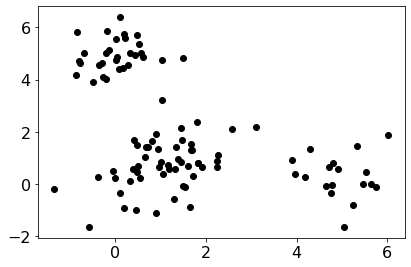

In [68]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [69]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20


In [70]:
results

{'weights': array([0.30071023, 0.1799371 , 0.51935267]),
 'means': array([[0.02138285, 4.947729  ],
        [4.94239235, 0.31365311],
        [1.08181125, 0.73903508]]),
 'covariances': array([[[ 0.2932614 ,  0.05048455],
         [ 0.05048455,  0.35281537]],
 
        [[ 0.3556437 , -0.01494875],
         [-0.01494875,  0.66695025]],
 
        [[ 0.67114992,  0.33058965],
         [ 0.33058965,  0.90429724]]]),
 'loglikelihood': [-541.3161248036661,
  -372.1355927865928,
  -366.99356972063583,
  -365.6599199288502,
  -364.33486476974326,
  -362.87960460172394,
  -361.37504027778317,
  -359.7842225540678,
  -357.8348658169412,
  -354.4429407838179,
  -347.33757513783434,
  -338.9500319134904,
  -336.1926973689691,
  -333.8130318590334,
  -329.78761702083597,
  -323.15808549033756,
  -319.5204134763917,
  -319.1101542516828,
  -318.91107575136516,
  -318.8437574328325,
  -318.8321411837265,
  -318.83092993526367,
  -318.830829251483,
  -318.83082148560914],
 'responsibility': array([[9.